In [1]:
from unity_dataset import UnityDataset

import os

import numpy as np

import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

from torchvision import transforms
from torchvision.utils import save_image

import matplotlib.pyplot as plt
%matplotlib inline

import time

In [2]:

NUM_EPOCHS = 10
LEARNING_RATE = 1e-3
BATCH_SIZE = 128

INPUT_IMAGE_DIR = "/media/blooker/Storage/gold-project-2021-images/480p/"

OUTPUT_IMAGE_DIR = "data/Data/Img"

transform = transforms.Compose([
    transforms.ToTensor()
])

In [3]:
dataset = UnityDataset(INPUT_IMAGE_DIR, img_size=(480, 360), patch_size=(120, 120), transform=transform)

train_set, test_set = torch.utils.data.random_split(dataset, [302676, 27516])

train_loader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=BATCH_SIZE, shuffle=True)

tensor(1.)


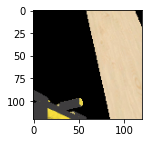

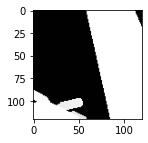

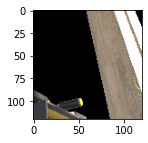

In [4]:
i = 114

plt.figure(figsize=(10,2))

x_img, x_dep, y = train_set[i]

print(x_dep.max())

img = x_img.permute(1,2,0)
plt.imshow(img)

plt.figure(figsize=(10,2))

img = x_dep.permute(1,2,0)
plt.imshow(img, cmap="gray")

plt.figure(figsize=(10,2))

img = y.permute(1,2,0)
plt.imshow(img)

In [5]:

def get_device():
    # if torch.cuda.is_available():
    #     device = "cuda:0"
    # else:
    #     device = "cpu"
    # return device

    return "cuda:0"

def make_dir():
    if not os.path.exists(OUTPUT_IMAGE_DIR):
        os.makedirs(OUTPUT_IMAGE_DIR)

def save_decoded_image(img, epoch):
    img = img.view(img.size(0), 3, 120, 120)
    path = ("./" + OUTPUT_IMAGE_DIR + "/linear_ae_image{}.png").format(epoch)
    save_image(img, path)

In [6]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # reg encoder
        self.enc1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.enc2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.enc3 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)

        # depth encoder
        self.enc_dep1 = nn.Conv2d(in_channels=1, out_channels=24, kernel_size=3, padding=1)
        self.enc_dep2 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=3, padding=1)
        self.enc_dep3 = nn.Conv2d(in_channels=24, out_channels=12, kernel_size=3, padding=1)

        # dense layer
        self.dense1 = nn.Linear(6300, 3150)
        self.dense2 = nn.Linear(3150, 1575)
        self.dense3 = nn.Linear(1575, 2700)

        # decoder
        self.dec1 = nn.ConvTranspose2d(in_channels=12, out_channels=24, kernel_size=2, stride=2)
        self.dec2 = nn.ConvTranspose2d(in_channels=24, out_channels=24, kernel_size=2, stride=2)
        self.dec3 = nn.ConvTranspose2d(in_channels=24, out_channels=3, kernel_size=2, stride=2)

    def forward(self, x_reg, x_dep):

        # enc1
        x_reg = F.relu(self.enc1(x_reg))
        x_reg = F.max_pool2d(x_reg, kernel_size=2, stride=2) # (32, 60, 60)

        x_dep = F.relu(self.enc_dep1(x_dep))
        x_dep = F.max_pool2d(x_dep, kernel_size=2, stride=2) # (24, 60, 60)

        # enc2
        x_reg = F.relu(self.enc2(x_reg))
        x_reg = F.max_pool2d(x_reg, kernel_size=2, stride=2) # (32, 30, 30)

        x_dep = F.relu(self.enc_dep2(x_dep))
        x_dep = F.max_pool2d(x_dep, kernel_size=2, stride=2) # (24, 30, 30)

        # enc3
        x_reg = F.relu(self.enc3(x_reg))
        x_reg = F.max_pool2d(x_reg, kernel_size=2, stride=2) # (16, 15, 15)

        x_dep = F.relu(self.enc_dep3(x_dep))
        x_dep = F.max_pool2d(x_dep, kernel_size=2, stride=2) # (12, 15, 15)

        # flatten and concatenate x_reg and x_dep
        x_reg = torch.flatten(x_reg, start_dim=1)
        x_dep = torch.flatten(x_dep, start_dim=1)

        x_reg = torch.cat((x_reg,x_dep), 1) # (128, 6300)

        # dense
        x_reg = F.relu(self.dense1(x_reg)) # (128, 3150)
        x_reg = F.relu(self.dense2(x_reg)) # (128, 1575)
        x_reg = F.relu(self.dense3(x_reg)) # (128, 2700)

        # reshape to format that dec1 can use
        x_reg = torch.reshape(x_reg, (-1, 12, 15, 15))

        # dec1
        x_reg = F.relu(self.dec1(x_reg)) # (24, 30, 30)

        # dec2
        x_reg = F.relu(self.dec2(x_reg)) # (24, 60, 60)

        # dec 3
        x_reg = F.relu(self.dec3(x_reg)) # (3, 120, 120)

        return x_reg

net = Autoencoder()
print(net)

Autoencoder(
  (enc1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc_dep1): Conv2d(1, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc_dep2): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc_dep3): Conv2d(24, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dense1): Linear(in_features=6300, out_features=3150, bias=True)
  (dense2): Linear(in_features=3150, out_features=1575, bias=True)
  (dense3): Linear(in_features=1575, out_features=2700, bias=True)
  (dec1): ConvTranspose2d(12, 24, kernel_size=(2, 2), stride=(2, 2))
  (dec2): ConvTranspose2d(24, 24, kernel_size=(2, 2), stride=(2, 2))
  (dec3): ConvTranspose2d(24, 3, kernel_size=(2, 2), stride=(2, 2))
)


In [7]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

In [8]:

def train(net, trainloader, NUM_EPOCHS):
    train_loss = []
    device = get_device()
    for epoch in range(NUM_EPOCHS):
        start_time = time.perf_counter()
        running_loss = 0.0
        for data in trainloader:
            x,x_dep,y = data
            # img = img.permute(0, 2, 3, 1)
            x = x.to(device, dtype=torch.float)
            x_dep = x_dep.to(device, dtype=torch.float)
            y = y.to(device, dtype=torch.float)

            optimizer.zero_grad()
            outputs = net(x, x_dep)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        loss = running_loss / len(trainloader)
        train_loss.append(loss)
        print("Epoch {} of {}, Train loss: {:.6f}, Time: {:.4f}".format(
            epoch+1, NUM_EPOCHS, loss, time.perf_counter()-start_time
        ))

        # if epoch % 5 == 0:
        save_decoded_image(outputs.cpu().data, epoch)

    return train_loss

In [20]:

def test_image_reconstruction(net, testloader):
    device = get_device()
    for batch in testloader:
        x, x_dep, _ = batch
        x = x.to(device, dtype=torch.float)
        x_dep = x_dep.to(device, dtype=torch.float)
        # img = img.view(img.size(0), -1)
        outputs = net(x, x_dep)
        outputs = outputs.view(outputs.size(0), 3, 120, 120).cpu().data
        save_image(outputs, "./" + OUTPUT_IMAGE_DIR + '/reconstruction.png')
        break

cuda:0
Epoch 1 of 10, Train loss: 0.027818, Time: 2824.9490
Epoch 2 of 10, Train loss: 0.020665, Time: 2840.4124
Epoch 3 of 10, Train loss: 0.018276, Time: 2843.9636
Epoch 4 of 10, Train loss: 0.016942, Time: 2851.1410
Epoch 5 of 10, Train loss: 0.015827, Time: 2851.9815
Epoch 6 of 10, Train loss: 0.014916, Time: 2844.7892
Epoch 7 of 10, Train loss: 0.014176, Time: 2845.9329
Epoch 8 of 10, Train loss: 0.013550, Time: 2838.8484
Epoch 9 of 10, Train loss: 0.012976, Time: 2822.9752
Epoch 10 of 10, Train loss: 0.012475, Time: 2793.6426


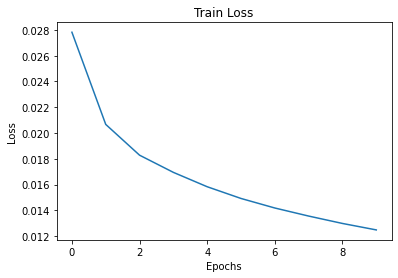

In [10]:

device = get_device()
print(device)

net.to(device)

make_dir()

train_loss = train(net, train_loader, NUM_EPOCHS)
plt.figure()
plt.plot(train_loss)
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig("./" + OUTPUT_IMAGE_DIR + "/deep_ae_loss.png")

In [24]:
net.to(device)
test_image_reconstruction(net, test_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


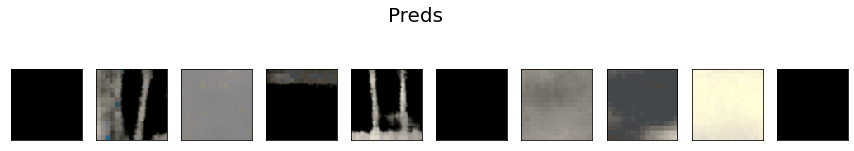

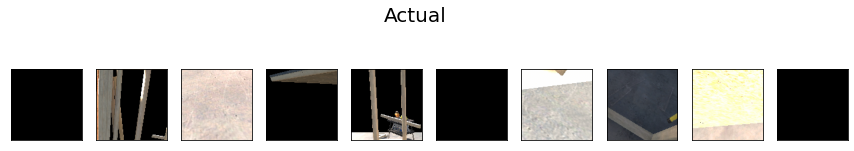

In [25]:
x_images = np.array([])
y_images = np.array([])

for batch in test_loader:
    x, x_dep, y = batch
    x = x.to(device, dtype=torch.float)
    x_dep = x_dep.to(device, dtype=torch.float)

    # img = img.view(img.size(0), -1)
    outputs = net(x, x_dep)

    outputs = outputs.view(outputs.size(0), 3, 120, 120).cpu().data

    y_images = y
    x_images = outputs

    save_image(x, "./" + OUTPUT_IMAGE_DIR + '/unlit.png')
    save_image(outputs, "./" + OUTPUT_IMAGE_DIR + '/reconstruction.png')
    save_image(y, "./" + OUTPUT_IMAGE_DIR + '/actual.png')
    break

def show_data(X, n=10, title=""):
    plt.figure(figsize=(15,5))
    for i in range(n):
        ax = plt.subplot(2,n,i+1)
        img = X[i].permute(1,2,0)
        plt.imshow(img)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.suptitle(title, fontsize=20)

show_data(x_images, title="Preds")
show_data(y_images, title="Actual")

In [26]:
# Input to the model
x = torch.randn(1, 3, 120, 120)
x_dep = torch.randn(1, 1, 120, 120)

net.cpu()

# Export the model
torch.onnx.export(net,                       # model being run
                  (x, x_dep),                         # model input (or a tuple for multiple inputs)
                  "./data/Data/model.onnx",       # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=9,           # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['enc1'],       # the model's input names
                  output_names = ['dec3']       # the model's output names
                  )